# Embedding Model Comparison for RAG Systems

This notebook evaluates and compares different embedding models for Retrieval-Augmented Generation (RAG) systems. We analyze performance metrics like embedding generation time, query response time, and relevance of retrieved documents across different embedding models.

## Models Compared
- Llama 3.2 (4096 dimensions)
- Nomic Embed (768 dimensions)
- BGE-M3 (1024 dimensions)

## Process Overview
1. Load and preprocess documents
2. Configure embedding models
3. Run test queries
4. Evaluate and visualize performance metrics

In [ ]:
# Install required dependencies
%pip install langchain langchain_community langchain_ollama langchain_text_splitters langchain_huggingface sentence-transformers pandas matplotlib faiss-cpu

## Setup and Dependencies

Import all required libraries for document loading, text splitting, embedding generation, evaluation, and visualization.

In [2]:
# Import all necessary libraries
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score

# Langchain imports
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_ollama import OllamaEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings

# Configure plot settings
plt.rcParams.update({'font.size': 14})

## Document Loading and Processing

Load text documents from a directory and split them into smaller, context-specific chunks for embedding and retrieval.

In [ ]:
# Load all text files from the specified directory
folder_path = "/workspaces/RAG_BOT/Embedding/sampledata"
document_loader = DirectoryLoader(folder_path, glob="**/*.txt", loader_cls=TextLoader)
raw_documents = document_loader.load()

print(f"Number of documents loaded: {len(raw_documents)}")
print("Documents loaded:")
print(raw_documents)

Number of documents loaded: 1
Documents loaded:
[Document(metadata={'source': '/workspaces/RAG_BOT/Embedding/sampledata/ApplicationManagement.txt'}, page_content='ENDPOINT: Get application templates and categories\nPATH: /SaasManage/GetTemplatesAndCategories\nMETHOD: POST\nTAGS: Application Management\nMETADATA:\n  * x-idap-anon: False\nRESPONSES:\n  Status Code: 200\n  Description: API-Result\n  Content Type: */*\n  Response Schema: SaasManageGetTemplatesAndCategories\n  Response Body Properties:\n    * Result (object): A list of application templates\n      Nested properties:\n        * Category (string): Application category\n        * DisplayName (string): Application template display name\n        * AppType (string): Application type\n        * AppTypeDisplayName (string): Display name of application type\n        * Icon (string): Path of application icon image\n        * WebAppType (string): Application web-app-type\n        * Description (string): Application description\n      

In [4]:
# Split each raw document based on dashed line and create sub-documents
split_documents = []
for doc in raw_documents:
    # Use regex to split based on dashed lines like '-----...'
    parts = re.split(r'-{5,}', doc.page_content)
    for i, part in enumerate(parts):
        cleaned_part = part.strip()
        if cleaned_part:
            split_documents.append(
                Document(
                    page_content=cleaned_part,
                    metadata={"source": doc.metadata["source"], "part": i + 1}
                )
            )

print(f"Total split chunks: {len(split_documents)}")

# Prepare documents with consistent metadata for embedding
documents = [
    Document(
        page_content=chunk.page_content,
        metadata=chunk.metadata
    ) for chunk in split_documents
]

Total split chunks: 35


## Embedding Models Configuration

Configure different embedding models with their respective dimensions for comparative evaluation.

In [5]:
# Set up embedding models with dimensions noted
embedding_models = {
    "HuggingFace": {
        "model": HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2"),
        "dimensions": 384
    },
    "Nomic": {
        "model": OllamaEmbeddings(model="nomic-embed-text:latest", base_url="http://localhost:11434"),
        "dimensions": 768
    },
    "BGE-M3": {
        "model": OllamaEmbeddings(model="bge-m3:567m", base_url="http://localhost:11434"),
        "dimensions": 1024
    }
}

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Vector Store Creation and Performance Testing

### 1. Create FAISS Vector Stores for Each Model

In [7]:
from langchain_community.vectorstores import FAISS
import time
import numpy as np
import matplotlib.pyplot as plt

# Dictionary to store vector stores
vector_stores = {}
embedding_times = {}

# Create vector stores for each model
for model_name, model_info in embedding_models.items():
    print(f"Creating vector store for {model_name}...")
    start_time = time.time()

    # Create vector store
    vector_store = FAISS.from_documents(
        documents,
        model_info["model"]
    )

    end_time = time.time()

    # Store vector store and embedding time
    vector_stores[model_name] = vector_store
    embedding_times[model_name] = end_time - start_time

    print(f"{model_name} - Embedding time: {embedding_times[model_name]:.2f} seconds")

Creating vector store for HuggingFace...
HuggingFace - Embedding time: 1.61 seconds
Creating vector store for Nomic...
Nomic - Embedding time: 71.15 seconds
Creating vector store for BGE-M3...
BGE-M3 - Embedding time: 215.74 seconds


### 2. Define Evaluation Metrics and Test Queries

In [ ]:
# Define test queries relevant to API documentation
test_queries = [
    "How do I delete an application?",
    "What is the endpoint for getting policy block?",
    "How to authenticate API requests?",
    "How to import apps from templates?",
    "How to get TOTP codes for secured password?",
    "What parameters are required for updating application?"
    #medium-to-hard level queries
    "How to securely retrieve and encrypt client secrets for OIDC web applications?",
    "What's the process for cloning an existing application with all its settings?",
    "How can I manage file attachments and storage space for secured items?",
    "What permissions are needed to set application access rights for other users?",
    "How to create and manage custom application tags for organizational purposes?"
]

# Function to evaluate retrieval performance
def evaluate_retrieval(vector_stores, queries, k=5):
    results = {}
    query_times = {}

    for model_name, vector_store in vector_stores.items():
        model_results = []
        model_query_times = []

        for query in queries:
            start_time = time.time()
            retrieved_docs = vector_store.similarity_search(query, k=k)
            end_time = time.time()

            query_time = end_time - start_time
            model_query_times.append(query_time)

            # Store results
            model_results.append({
                'query': query,
                'docs': retrieved_docs,
                'time': query_time
            })

        results[model_name] = model_results
        query_times[model_name] = model_query_times

    return results, query_times

### 3. Perform Evaluation and Collect Metrics

In [ ]:
# Evaluate models with different k values
k_values = [3, 5, 10]
evaluation_results = {}
query_time_results = {}

for k in k_values:
    print(f"\nEvaluating with k={k}:")
    results, query_times = evaluate_retrieval(vector_stores, test_queries, k=k)
    evaluation_results[k] = results
    query_time_results[k] = query_times

    # Print average query times
    for model_name, times in query_times.items():
        avg_time = sum(times) / len(times)
        print(f"{model_name} - Avg query time: {avg_time:.4f} seconds")


Evaluating with k=3:
HuggingFace - Avg query time: 0.0132 seconds
Nomic - Avg query time: 0.0788 seconds
BGE-M3 - Avg query time: 0.2614 seconds

Evaluating with k=5:
HuggingFace - Avg query time: 0.0108 seconds
Nomic - Avg query time: 0.0722 seconds
BGE-M3 - Avg query time: 0.2543 seconds

Evaluating with k=10:
HuggingFace - Avg query time: 0.0116 seconds
Nomic - Avg query time: 0.0724 seconds
BGE-M3 - Avg query time: 0.2571 seconds


### 4. Relevance Scoring Function

In [ ]:
def score_relevance(results, queries):
    """
    Automatically score relevance of retrieved documents on a scale of 0-3
    
    Args:
        results: Dictionary of retrieval results
        queries: List of test queries
        
    Returns:
        relevance_scores: Dictionary of relevance scores for each model and query
        
    Scoring scale:
    0: Not relevant
    1: Somewhat relevant
    2: Relevant
    3: Highly relevant
    """
    relevance_scores = {}

    for model_name, model_results in results.items():
        model_scores = []

        for i, result in enumerate(model_results):
            query = queries[i]
            docs = result['docs']

            query_terms = set(query.lower().split())

            doc_scores = []
            for doc in docs:
                content = doc.page_content.lower()

                # Check if content contains API endpoint information related to query
                score = 0
                matched_terms = 0

                for term in query_terms:
                    if term in content:
                        matched_terms += 1

                # Calculate score based on term matches and presence of relevant API patterns
                term_ratio = matched_terms / len(query_terms) if query_terms else 0

                if term_ratio > 0.7 or (
                    ("endpoint" in content or "path" in content) and term_ratio > 0.3):
                    score = 3  # Highly relevant
                elif term_ratio > 0.5 or (
                    ("method" in content or "parameters" in content) and term_ratio > 0.2):
                    score = 2  # Relevant
                elif term_ratio > 0.3 or "tags" in content:
                    score = 1  # Somewhat relevant

                doc_scores.append(score)

            model_scores.append(doc_scores)

        relevance_scores[model_name] = model_scores

    return relevance_scores

### 5. Calculate NDCG Scores

In [1]:
def calculate_ndcg(relevance_scores, k=5):
    """
    Calculate NDCG scores for each model and query
    
    Args:
        relevance_scores: Dictionary of relevance scores
        k: Number of documents to consider
        
    Returns:
        ndcg_scores: Dictionary of NDCG scores for each model
    """
    ndcg_scores = {}

    for model_name, model_scores in relevance_scores.items():
        model_ndcg = []

        for query_scores in model_scores:
            # Ensure we only use up to k scores
            scores = query_scores[:k]

            # Create ideal scores (sorted in descending order)
            ideal_scores = sorted(scores, reverse=True)

            # Calculate NDCG using scikit-learn
            if any(scores):  # Only calculate if there are any non-zero scores
                ndcg = ndcg_score(np.array([ideal_scores]), np.array([scores]))
                model_ndcg.append(ndcg)
            else:
                model_ndcg.append(0)

        ndcg_scores[model_name] = model_ndcg

    return ndcg_scores

### 6. Visualizations for Comparison

In [ ]:
def visualize_results(embedding_times, query_times, ndcg_scores):
    """
    Create visualizations to compare models
    
    Args:
        embedding_times: Dictionary of embedding times for each model
        query_times: Dictionary of query times for each model
        ndcg_scores: Dictionary of NDCG scores for each model
    """
    models = list(embedding_times.keys())

    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Plot embedding times
    axes[0].bar(models, [embedding_times[model] for model in models])
    axes[0].set_title('Document Embedding Time (seconds)')
    axes[0].set_ylabel('Time (s)')
    axes[0].grid(axis='y', alpha=0.3)

    # Plot average query times
    avg_query_times = [np.mean(query_times[model]) for model in models]
    axes[1].bar(models, avg_query_times)
    axes[1].set_title('Average Query Time (seconds)')
    axes[1].set_ylabel('Time (s)')
    axes[1].grid(axis='y', alpha=0.3)

    # Plot average NDCG scores
    avg_ndcg = [np.mean(ndcg_scores[model]) for model in models]
    axes[2].bar(models, avg_ndcg)
    axes[2].set_title('Average NDCG Score')
    axes[2].set_ylabel('NDCG Score')
    axes[2].set_ylim(0, 1)
    axes[2].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Create additional plot for dimension comparison
    dimensions = [embedding_models[model]["dimensions"] for model in models]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(models, dimensions)
    ax.set_title('Embedding Dimensions by Model')
    ax.set_ylabel('Dimensions')
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

## Evaluation Results and Analysis

### 7. Run Evaluation and Display Results


Full evaluation with k=5:
HuggingFace - Avg NDCG: 0.9707
Nomic - Avg NDCG: 0.9485
BGE-M3 - Avg NDCG: 0.9424


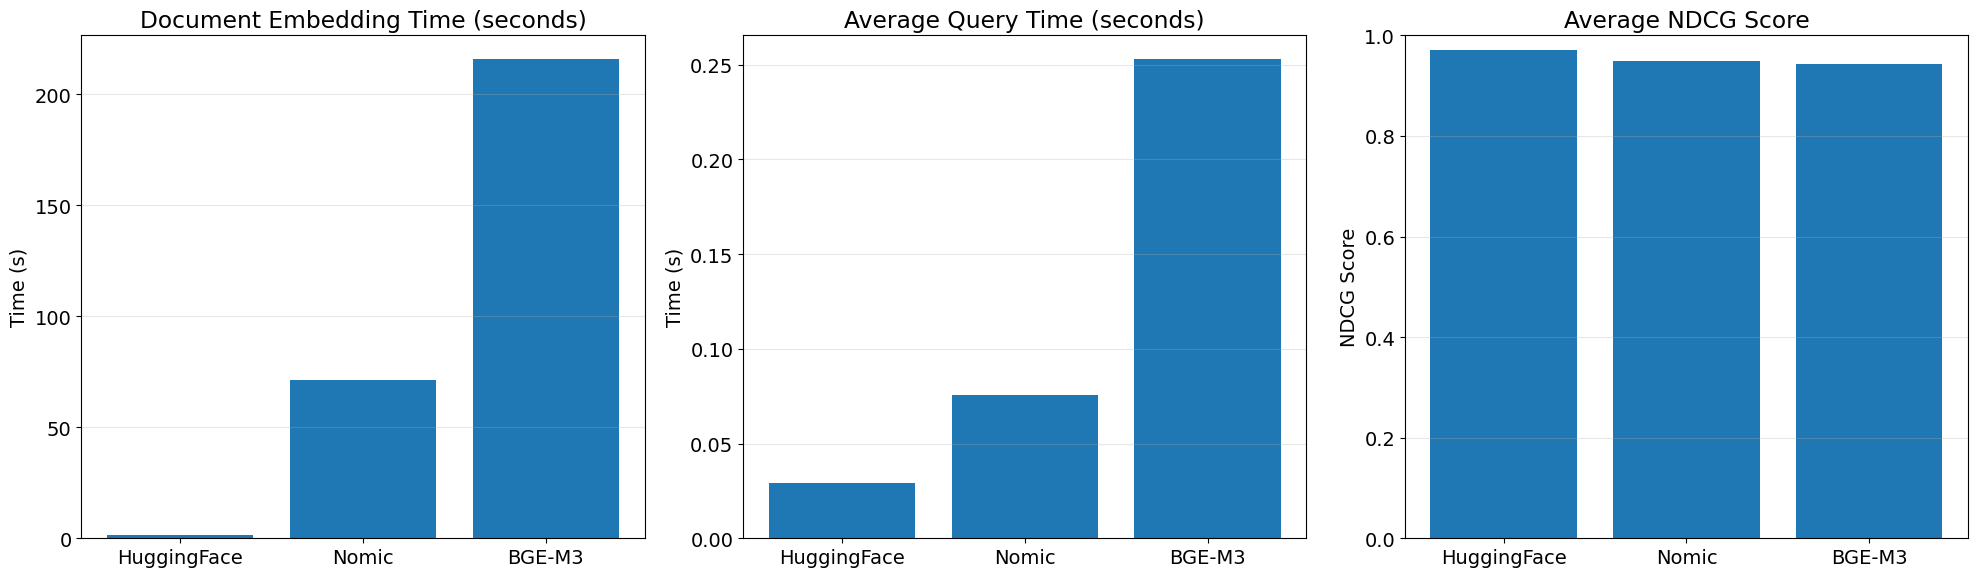

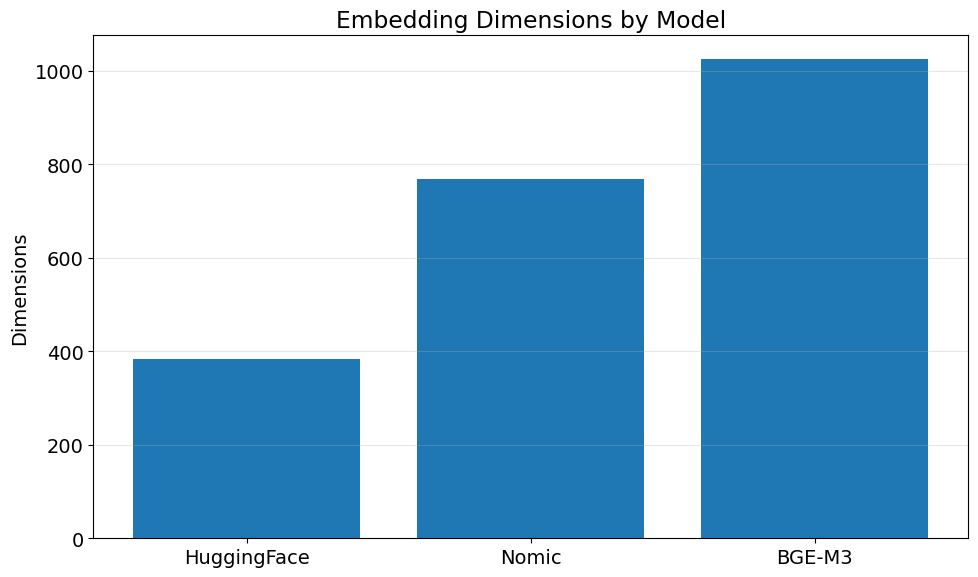

,Model,Embedding Time (s),Avg Query Time (s),Avg NDCG Score,Dimensions
0,HuggingFace,1.613142,0.029341,0.970713,384.0
1,Nomic,71.151549,0.075557,0.948509,768.0
2,BGE-M3,215.737526,0.252888,0.942431,1024.0


In [ ]:
# Run the full evaluation
for k in [5]:  # Using k=5 for the main evaluation
    print(f"\nFull evaluation with k={k}:")
    results, query_times = evaluate_retrieval(vector_stores, test_queries, k=k)

    # Score relevance
    relevance_scores = score_relevance(results, test_queries)

    # Calculate NDCG
    ndcg_scores = calculate_ndcg(relevance_scores, k)

    # Print average NDCG scores
    for model_name, scores in ndcg_scores.items():
        avg_ndcg = sum(scores) / len(scores)
        print(f"{model_name} - Avg NDCG: {avg_ndcg:.4f}")

    # Visualize results
    visualize_results(embedding_times, query_times, ndcg_scores)

    # Create detailed report
    report_df = pd.DataFrame({
        'Model': [],
        'Embedding Time (s)': [],
        'Avg Query Time (s)': [],
        'Avg NDCG Score': [],
        'Dimensions': []
    })

    for model_name in embedding_models.keys():
        report_df = pd.concat([report_df, pd.DataFrame({
            'Model': [model_name],
            'Embedding Time (s)': [embedding_times[model_name]],
            'Avg Query Time (s)': [np.mean(query_times[model_name])],
            'Avg NDCG Score': [np.mean(ndcg_scores[model_name])],
            'Dimensions': [embedding_models[model_name]["dimensions"]]
        })], ignore_index=True)

    display(report_df)

### 8. Analyze API-Specific Performance

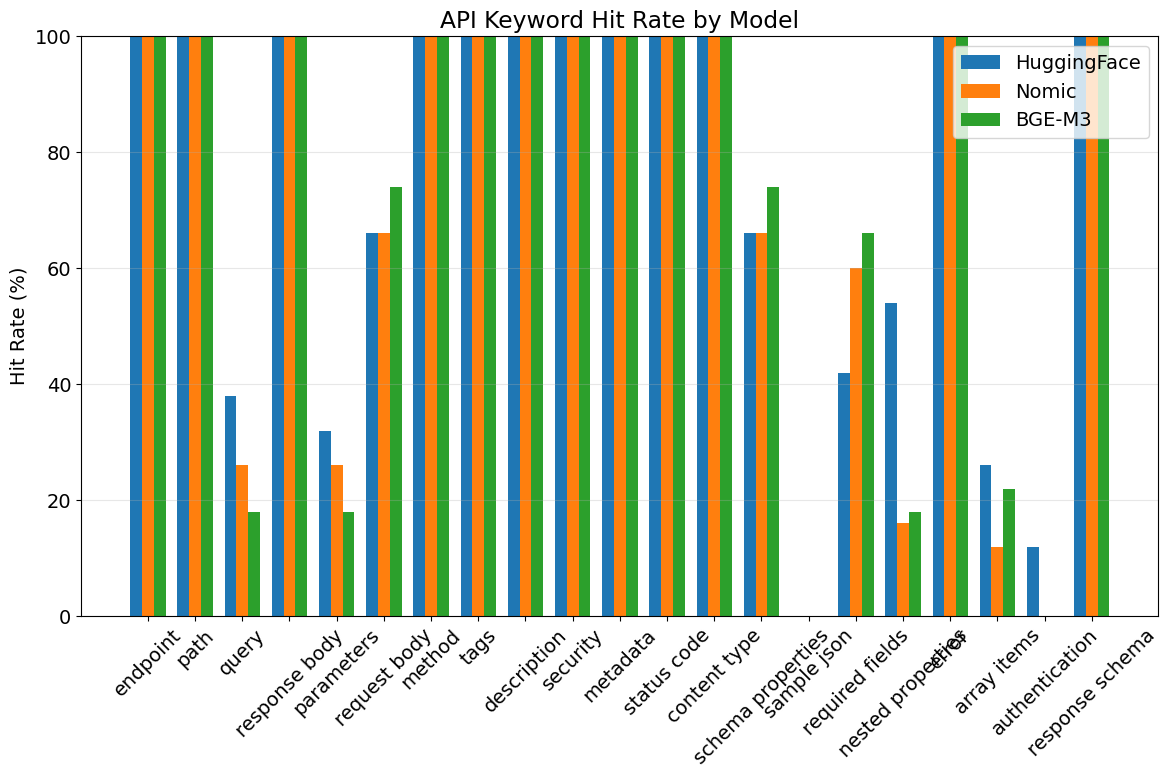

In [ ]:
def analyze_api_retrieval(results, test_queries):
    """
    Analyze how well each model retrieves API-specific information
    
    Args:
        results: Dictionary of retrieval results
        test_queries: List of test queries
        
    Returns:
        api_hit_rates: Dictionary of API keyword hit rates for each model
    """
    api_keywords = [
        'endpoint', 'path', 'query', 'response body', 'parameters', 'request body',
        'method', 'tags', 'description', 'security', 'metadata', 'status code',
        'content type', 'schema properties', 'sample json', 'required fields',
        'nested properties', 'error', 'array items', 'authentication', 'response schema'
    ]

    api_hit_rates = {}

    for model_name, model_results in results.items():
        keyword_hits = {keyword: 0 for keyword in api_keywords}
        total_docs = 0

        for i, result in enumerate(model_results):
            docs = result['docs']
            total_docs += len(docs)

            for doc in docs:
                content = doc.page_content.lower()
                for keyword in api_keywords:
                    if keyword in content:
                        keyword_hits[keyword] += 1

        # Calculate percentage of hits for each keyword
        for keyword in api_keywords:
            keyword_hits[keyword] = (keyword_hits[keyword] / total_docs) * 100

        api_hit_rates[model_name] = keyword_hits

    # Visualize API keyword hit rates
    models = list(api_hit_rates.keys())
    keywords = list(api_hit_rates[models[0]].keys())

    fig, ax = plt.subplots(figsize=(12, 8))

    x = np.arange(len(keywords))
    width = 0.25
    multiplier = 0

    for model_name in models:
        offset = width * multiplier
        rects = ax.bar(x + offset, [api_hit_rates[model_name][k] for k in keywords], width, label=model_name)
        multiplier += 1

    ax.set_title('API Keyword Hit Rate by Model')
    ax.set_xticks(x + width, keywords)
    ax.set_ylabel('Hit Rate (%)')
    ax.set_ylim(0, 100)
    ax.legend(loc='best')
    ax.grid(axis='y', alpha=0.3)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return api_hit_rates

# Run API-specific analysis
api_hit_rates = analyze_api_retrieval(evaluation_results[5], test_queries)


    ## Model Recommendation

    Based on the evaluation metrics, the recommended embedding model is **HuggingFace**.

    ### Reasoning:
    - Embedding time: 1.61s (BGE-M3 has 215.74s)
    - Average query time: 0.0293s
    - NDCG score: 0.9707
    - Dimensions: 384

    This model provides the best balance between retrieval quality and performance for your API documentation use case.
    


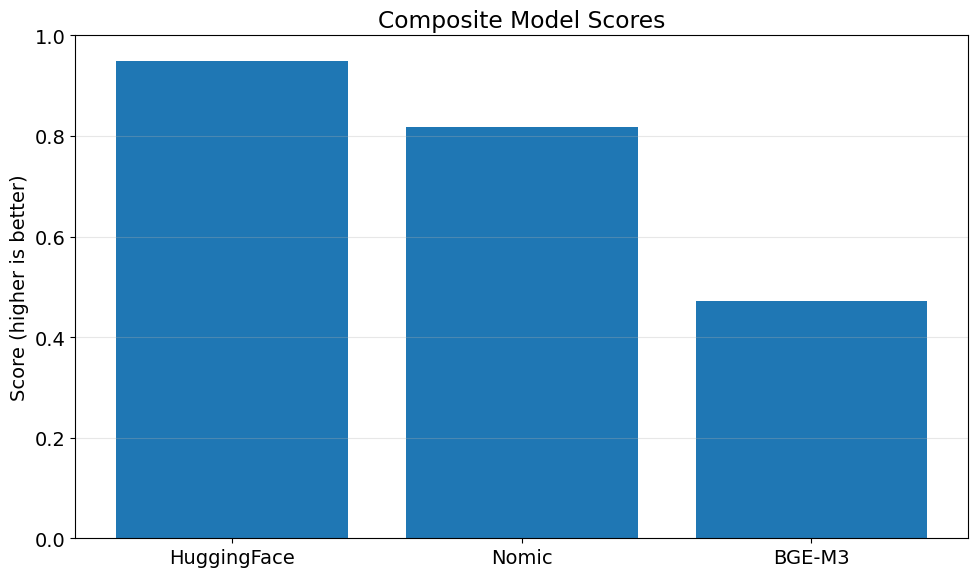

In [ ]:
def recommend_best_model(embedding_times, query_times, ndcg_scores, dimensions):
    """
    Recommend the best model based on combined metrics
    
    Args:
        embedding_times: Dictionary of embedding times
        query_times: Dictionary of query times
        ndcg_scores: Dictionary of NDCG scores
        dimensions: Dictionary of embedding dimensions
        
    Returns:
        best_model: Name of the best model
        composite_scores: Dictionary of composite scores for each model
    """
    models = list(embedding_times.keys())

    # Normalize metrics (lower is better for times, higher is better for NDCG)
    max_embed_time = max(embedding_times.values())
    max_query_time = max([np.mean(query_times[model]) for model in models])

    norm_embed_times = {model: 1 - (embedding_times[model] / max_embed_time) for model in models}
    norm_query_times = {model: 1 - (np.mean(query_times[model]) / max_query_time) for model in models}
    norm_ndcg = {model: np.mean(ndcg_scores[model]) for model in models}

    # Calculate composite score with weighted metrics
    weights = {
        'embedding_time': 0.2,  # Less important for one-time operations
        'query_time': 0.3,      # Important for user experience
        'ndcg': 0.5             # Most important for retrieval quality
    }

    composite_scores = {}
    for model in models:
        score = (
            weights['embedding_time'] * norm_embed_times[model] +
            weights['query_time'] * norm_query_times[model] +
            weights['ndcg'] * norm_ndcg[model]
        )
        composite_scores[model] = score

    # Find best model
    best_model = max(composite_scores, key=composite_scores.get)

    # Create recommendation text
    recommendation = f"""
    ## Model Recommendation

    Based on the evaluation metrics, the recommended embedding model is **{best_model}**.

    ### Reasoning:
    - Embedding time: {embedding_times[best_model]:.2f}s ({max(embedding_models.items(), key=lambda x: x[1]['dimensions'])[0]} has {max_embed_time:.2f}s)
    - Average query time: {np.mean(query_times[best_model]):.4f}s
    - NDCG score: {np.mean(ndcg_scores[best_model]):.4f}
    - Dimensions: {embedding_models[best_model]['dimensions']}

    This model provides the best balance between retrieval quality and performance for your API documentation use case.
    """

    print(recommendation)

    # Plot composite scores
    plt.figure(figsize=(10, 6))
    plt.bar(models, [composite_scores[model] for model in models])
    plt.title('Composite Model Scores')
    plt.ylabel('Score (higher is better)')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return best_model, composite_scores

# Generate recommendation
best_model, scores = recommend_best_model(
    embedding_times,
    query_times,
    ndcg_scores,
    {model: info["dimensions"] for model, info in embedding_models.items()}
)

## Process and Embed Full Dataset

Load the complete processed dataset for embedding with the best model.

In [ ]:
# Load all text files from the specified directory with robust encoding handling
import os
from langchain_community.document_loaders import TextLoader

# Define folder path
folder_path = "/workspaces/RAG_BOT/ProcessedData"

# Create a custom loading function to handle encoding issues
def load_with_flexible_encoding(file_path):
    """
    Load a text file with fallback encodings if the default fails
    
    Args:
        file_path: Path to the text file
        
    Returns:
        list: List of document objects
    """
    # Try different encodings in this order
    encodings = ['utf-8', 'latin-1', 'cp1252']

    for encoding in encodings:
        try:
            loader = TextLoader(file_path, encoding=encoding)
            return loader.load()
        except UnicodeDecodeError:
            print(f"Encoding {encoding} failed for {os.path.basename(file_path)}, trying next...")
        except Exception as e:
            print(f"Error loading {os.path.basename(file_path)}: {str(e)}")
            return []

    print(f"All encodings failed for {os.path.basename(file_path)}")
    return []

# Manually process each file in the directory
raw_documents = []
for root, _, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.txt'):
            file_path = os.path.join(root, file)
            print(f"Loading {os.path.basename(file_path)}...")
            docs = load_with_flexible_encoding(file_path)
            raw_documents.extend(docs)

print(f"\nTotal documents loaded: {len(raw_documents)}")
if raw_documents:
    print(f"Sample document from: {os.path.basename(raw_documents[0].metadata['source'])}")
    print(f"Content preview: {raw_documents[0].page_content[:150]}...")

Loading PolicyMangement.txt...
Loading ApplicationManagement.txt...
Loading UserManagement.txt...

Total documents loaded: 3
Sample document from: PolicyMangement.txt
Content preview: ENDPOINT: Delete authentication profile
PATH: /AuthProfile/DeleteProfile
METHOD: POST
TAGS: Authentication Profile
METADATA:
  * x-idap-anon: False
  ...


In [19]:
# Split each raw document based on dashed line and create sub-documents
split_documents = []
for doc in raw_documents:
    # Use regex to split based on dashed lines like '-----...'
    parts = re.split(r'-{5,}', doc.page_content)
    for i, part in enumerate(parts):
        cleaned_part = part.strip()
        if cleaned_part:
            split_documents.append(
                Document(
                    page_content=cleaned_part,
                    metadata={"source": doc.metadata["source"], "part": i + 1}
                )
            )

print(f"Total split chunks: {len(split_documents)}")

# Prepare documents with consistent metadata for embedding
documents = [
    Document(
        page_content=chunk.page_content,
        metadata=chunk.metadata
    ) for chunk in split_documents
]

Total split chunks: 77


In [ ]:
# Save the best model's FAISS vector store to a local file
import os

# Create output directory if it doesn't exist
output_dir = "/workspaces/RAG_BOT/LocalEmbeddings"
os.makedirs(output_dir, exist_ok=True)

print(f"Using best model: {best_model}")

# Get the best model's embedding function
best_embedding_model = embedding_models[best_model]["model"]
dimensions = embedding_models[best_model]["dimensions"]

# Create the vector store with the best model
final_vector_store = FAISS.from_documents(documents, best_embedding_model)

# Save the vector store to disk
vector_store_path = os.path.join(output_dir, f"{best_model.lower()}_faiss_index")
final_vector_store.save_local(vector_store_path)

print(f"FAISS vector store saved to '{vector_store_path}'")

Using best model: HuggingFace


## Process Enriched Chunks

Load and process enriched API documentation chunks.

In [ ]:
# Load all text files from the specified directory with robust encoding handling
import os
from langchain_community.document_loaders import TextLoader

# Define folder path
folder_path = "/workspaces/RAG_BOT/PIVIOT/enriched_endpoints"


def load_with_flexible_encoding(file_path):
    """Load a text file with fallback encodings if the default fails"""

    encodings = ['utf-8', 'latin-1', 'cp1252']

    for encoding in encodings:
        try:
            loader = TextLoader(file_path, encoding=encoding)
            return loader.load()
        except UnicodeDecodeError:
            print(f"Encoding {encoding} failed for {os.path.basename(file_path)}, trying next...")
        except Exception as e:
            print(f"Error loading {os.path.basename(file_path)}: {str(e)}")
            return []

    print(f"All encodings failed for {os.path.basename(file_path)}")
    return []

# Manually process each file in the directory
raw_documents = []
for root, _, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.txt'):
            file_path = os.path.join(root, file)
            print(f"Loading {os.path.basename(file_path)}...")
            docs = load_with_flexible_encoding(file_path)
            raw_documents.extend(docs)

print(f"\nTotal documents loaded: {len(raw_documents)}")
if raw_documents:
    print(f"Sample document from: {os.path.basename(raw_documents[0].metadata['source'])}")
    print(f"Content preview: {raw_documents[0].page_content[:150]}...")

Loading PolicyMangement_endpoint_007.txt...
Loading PolicyMangement_endpoint_009.txt...
Loading PolicyMangement_endpoint_006.txt...
Loading PolicyMangement_endpoint_002.txt...
Loading PolicyMangement_endpoint_003.txt...
Loading PolicyMangement_endpoint_001.txt...
Loading PolicyMangement_endpoint_005.txt...
Loading PolicyMangement_endpoint_004.txt...
Loading PolicyMangement_endpoint_008.txt...

Total documents loaded: 9
Sample document from: PolicyMangement_endpoint_007.txt
Content preview: **Human-Friendly Summary**

Get the authentication assurance level (AAL) for an individual's profile.

**Key Search Terms**...


## Process Split Chunks

Load data from enriched sources and split it into overlapping chunks for improved retrieval.

In [ ]:
import os
import glob
from sentence_transformers import SentenceTransformer
import numpy as np

DATA_DIR = "/workspaces/RAG_BOT/EnrichedData" 
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 200



def split_with_overlap(text, chunk_size, overlap):
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunks.append(text[start:end])
        if end >= len(text):
            break
        start += chunk_size - overlap
    return chunks


all_chunks = []
all_metadatas = []

for filepath in glob.glob(os.path.join(DATA_DIR, "*.txt")):
    with open(filepath, "r", encoding="utf-8") as f:
        text = f.read()

    # Split into overlapping chunks
    chunks = split_with_overlap(text, CHUNK_SIZE, CHUNK_OVERLAP)

    for idx, chunk in enumerate(chunks):
        all_chunks.append(chunk)
        all_metadatas.append({
            "source_file": os.path.basename(filepath),
            "chunk_id": idx
        })

print(f"Total chunks created: {len(all_chunks)}")


Total chunks created: 288


In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings


output_dir = "/workspaces/RAG_BOT/LocalEmbeddings"

os.makedirs(output_dir, exist_ok=True)


# using the best model's embedding function
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2") 
final_vector_store = FAISS.from_texts(all_chunks, embedding_model)


# Save the vector store to disk
vector_store_path = os.path.join(output_dir, f"Hugging_split_enriched_faiss_index")
final_vector_store.save_local(vector_store_path)
print(f"FAISS vector store saved to '{vector_store_path}'")